In [0]:
!nvidia-smi

Tue Apr 21 09:37:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import os
os.chdir('/content/drive/My Drive/GP/src')
print(os.getcwd())
#print(os.listdir())

/content/drive/My Drive/GP/src


In [0]:
!python CHASEDB_train.py

tcmalloc: large alloc 8383365120 bytes == 0x8bfa000 @  0x7eff8c900001 0x7eff8a162765 0x7eff8a1c6dc0 0x7eff8a1c8c5f 0x7eff8a25f238 0x50ac25 0x50d390 0x509d48 0x50aa7d 0x50c5b9 0x508245 0x509642 0x595311 0x54a6ff 0x551b81 0x5aa6ec 0x50abb3 0x50d390 0x508245 0x50b403 0x635222 0x6352d7 0x638a8f 0x639631 0x4b0f40 0x7eff8c4fbb97 0x5b2fda
tcmalloc: large alloc 8383365120 bytes == 0x1fcf34000 @  0x7eff8c900001 0x7eff8a162765 0x7eff8a1c6dc0 0x7eff8a1c8c5f 0x7eff8a25f238 0x50ac25 0x50d390 0x509d48 0x50aa7d 0x50c5b9 0x508245 0x509642 0x595311 0x54a6ff 0x551b81 0x5aa6ec 0x50abb3 0x50d390 0x508245 0x50b403 0x635222 0x6352d7 0x638a8f 0x639631 0x4b0f40 0x7eff8c4fbb97 0x5b2fda
tcmalloc: large alloc 8383365120 bytes == 0x3f1234000 @  0x7eff8c8e0b6b 0x7eff8c900379 0x7eff3105ab4a 0x7eff3105c5fa 0x7eff3338c78a 0x7eff335d530b 0x7eff3361cb37 0x7eff355dc795 0x7eff3361cb37 0x7eff33385346 0x7eff333870d6 0x7eff336cabf3 0x7eff353b0db2 0x7eff3371564a 0x7eff7c4ab24b 0x7eff7c4a5229 0x7eff7c4a5fa5 0x7eff7c0f0d71 0x5

KeyboardInterrupt: ignored

{'TP': 36059, 'TN': 902803, 'FP': 5118, 'FN': 15060, 'acc': 0.9789602102102092, 'sn': 0.8757073123345345, 'sp': 0.98359232260152, 'rc': 0.7053932979909485, 'f1': 0.7813773072981051, 'jac': 0.6411970766577051}
0.9876695332927263


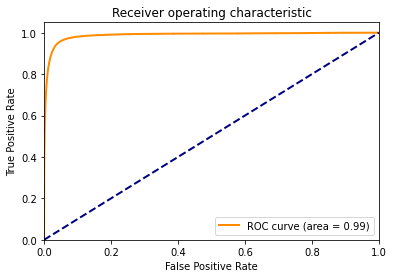

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 18 15:19:35 2020

@author: zll
"""

import cv2 as cv
import numpy as np
import imageio
import torch
from preprocessing import my_proc
from MF_UNet2 import MF_U_Net
from U_Net2 import U_Net
from math import floor, ceil
from metrics import metrics, roc


def seg_img(net, img_file, mask_file=None):
    '''
    arguments:
        net: initialized model
        img_file: str, image(before preprocess) file name
        mask_file: str, mask(if there is) file name
    returns:
        (pred: segment prediction, 2-D numpy byte array, 0 and 255, \
         out: net output before thresholding, 2-D numpy float32 array)
    '''
    # read images
    img = cv.imread(img_file)
    if img is None:    # cv2 cannot read gif
        img = imageio.mimread(img_file)  # but imageio can
    if mask_file is not None:
        msk = cv.imread(mask_file, cv.IMREAD_GRAYSCALE)
        if msk is None:
            msk = imageio.mimread(mask_file)[0]

    # preprocess
    proc = my_proc(np.uint8([img]))[0]  # numpy array of uint8
    shape = ((proc.shape[0] // 8 + 1) * 8,
             (proc.shape[1] // 8 + 1) * 8)  # shape of inputs
    inputs = np.empty(shape, dtype='float32')  # inputs of net
    # may need padding
    pad = (floor((shape[0] - proc.shape[0]) / 2),
           ceil((shape[0] - proc.shape[0]) / 2),
           floor((shape[1] - proc.shape[1]) / 2),
           ceil((shape[1] - proc.shape[1]) / 2))
    inputs[pad[0]: -pad[1], pad[2]: -pad[3]] = proc
    # convert to 4-D
    inputs = inputs.reshape((1, 1, shape[0], shape[1]))
    # normalization
    inputs /= 255
    inputs = torch.tensor(inputs)

    out = net(inputs)
    out = out[0, 1, :, :]
    # remove padding
    out = out[pad[0]: -pad[1], pad[2]: -pad[3]]
    # prediction, thresholding by 0.5
    pred = np.uint8(out >= 0.5)
    pred *= 255
    out = out.detach().numpy()

    # mask
    if mask_file is not None:
        for i in range(pred.shape[0]):
            for j in range(pred.shape[1]):
                pred[i, j] = pred[i, j] if msk[i, j] == 255 else 0

    return pred, out  # out may be used in roc


if __name__ == '__main__':
    model = MF_U_Net()
    model.eval()
    model.load_state_dict(torch.load('chase90.pkl',
                    map_location=torch.device('cpu')))
    '''
    pred, out = seg_img(model,
                '../data/DRIVE/test/proc_imgs/01_test.tif',
                '../data/DRIVE/test/mask/01_test_mask.gif')
    '''
    pred, out = seg_img(model,
             '../data/CHASEDB/test/image/Image_11L.jpg')
    
    '''cv.imshow('img', pred)
    cv.waitKey(0)
    cv.destroyAllWindows()'''
    #lable_file = '../data/DRIVE/test/1st_manual/01_manual1.gif'
    lable_file = '../data/CHASEDB/test/label/Image_11L_1stHO.png'
    target = cv.imread(lable_file, cv.IMREAD_GRAYSCALE)
    if target is None:    # cv2 cannot read gif
        target = imageio.mimread(lable_file)[0]  # but imageio can
    met = metrics(pred, target)
    auroc = roc(target, out)
    print(met)
    print(auroc)
    cv.imwrite('Image11_epoch90.jpg', pred)


In [0]:
np.save('out.npy', out)

In [0]:
import numpy as np
l = list()
for i in range(12):
    l.append(np.zeros(shape=(1024, 1024, 1024), dtype='uint8'))
